<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/06_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

이 노트북을 코랩에서 실행하려면 Pro 버전이 필요할 수 있습니다.

In [1]:
# 코랩을 사용하지 않으면 다음 코드를 주석 처리하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=6)

Cloning into 'nlp-with-transformers'...
remote: Enumerating objects: 653, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 653 (delta 47), reused 15 (delta 8), pack-reused 569
Receiving objects: 100% (653/653), 62.41 MiB | 20.09 MiB/s, done.
Resolving deltas: 100% (335/335), done.
/content/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.35.2
Using datasets v2.17.0
Using accelerate v0.27.0
Using sentencepiece v0.1.99
Using sacrebleu v2.4.0
Using rouge_score
Using nltk v3.8.1
Using py7zr v0.20.8


In [5]:
from transformers import pipeline, set_seed



# 6. 요약

- 사전에 훈련된 트랜스포머를 사용해 문서를 요약
- 요약은 입력과 출력이 텍스트인 고전적인 시퀀스-투-시퀀스(seq2seq) 작업임
- 인코더-디코더 모델을 통해 여러 사람이 주고 받은 대화를 간결하게 요약

## 6.1 CNN/DailyMail 데이터셋

- CNN/DailyMail 데이터셋은 300,000개 뉴스 기사와 요약의 쌍으로 구성됨
- 요약은 CNN과 DailyMail이 기사에 첨부한 글머리 목록의 내용
- 요약이 본문에서 추출되지 않고 추상적이라는 특징이 있음
  + 즉, 단순한 발췌가 아니라 새로운 문장으로 구성됨

- 여기서는 요약을 위해 익명화 처리를 하지 않은 3.0.0  버전을 사용

In [7]:
from datasets import load_dataset

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
print(f"특성: {dataset['train'].column_names}")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for ccdv/cnn_dailymail contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/cnn_dailymail
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

특성: ['article', 'highlights', 'id']


이 데이터세의 세 가지 feature
- article: 뉴스 기사를 담은 제목
- highlights: 요약에 해당하는 내용
- id: 기사의 고유 아이디

In [8]:
sample = dataset["train"][1]
print(f"""기사 (500개 문자 발췌, 총 길이: {len(sample["article"])}):""")
print(sample["article"][:500])
print(f'\n요약 (길이: {len(sample["highlights"])}):')
print(sample["highlights"])

기사 (500개 문자 발췌, 총 길이: 3192):
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay. The fastest man in the world charged clear of United States rival Justin
Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel
Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds
with Canada taking the bronze after Britain were disqualified for a faulty
handover. The 26-year-old Bolt has n

요약 (길이: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


기사가 요약에 비해 매우 긴 경우도 있음
- 트랜스포머 모델의 입력 토큰 제한을 위해 데이터 truncation 실시


## 6.2 텍스트 요약 파이프라인

- 트랜스포머 입력 토큰 제한을 위해 2,000자로 제한

In [9]:
sample_text = dataset["train"][1]["article"][:2000]
# 딕셔너리에 각 모델이 생성한 요약을 저장합니다.
summaries = {}

요약에서는 관례적으로 요약 문장을 줄바꿈으로 나눔
- 마침표마다 줄바꿈 토큰을 추가해도 되지만 그러면 'U.S.' 나 'U.N'과 같은 상용구의 처리가 어려움
- NLTK 패키지에는 문장의 종결과 약어에 등장하는 구두점 구별을 위한 알고리즘 있음
  + NLTK(Natural Language Toolkit)

  

In [10]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [11]:
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

['The U.S. are a country.', 'The U.N. is an organization.']

### 6.2.1 요약 기준 모델

기사를 요약하는 일반적인 기준 모델(baseline)은 단순히 기사에서 맨 처음 문장 세개를 선택하는 모델을 사용
- NLTK 문장 토크나이저로 쉽게 구현 가능

In [12]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

In [13]:
summaries["baseline"] = three_sentence_summary(sample_text)

### 6.2.2 GPT-2

- `TL:DR`: Too long, didn't read
- 텍스트 생성 파이프라인을 만들고 대용량 GPT-2 모델을 로드함


In [14]:
from transformers import pipeline, set_seed

set_seed(42)

# 코랩의 경우 gpt2-xl을 사용하면 메모리 부족 에러가 발생합니다.
# 대신 "gpt" 또는 "gpt2-large"로 지정하거나 코랩 프로를 사용하세요.
pipe = pipeline("text-generation", model="gpt2-xl")

gpt2_query = sample_text + "\nTL;DR:\n"
pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)
summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### 6.2.3 T5

- NLP에서 포괄적인 전이 학습 연구를 수행하기 위해 Text-to-Text 작업을 구성하는 범용 트랜스포머 아키텍처
- T5 체크포인트는 요약을 포함해 여러 작업에서(마스킹된 단어를 재구성하기 위한) 비지도 학습 데이터와 지도 학습 데이터를 섞은 데이터로 훈련됨
- 따라서, 미세튜닝 없이 이 체크포인트를 사전 훈련에 썼던 것과 동일한 프롬프트를 사용해 바로 요약할 수 있음
  + 문서 요약에 사용할 모델의 입력 포맷은 `summarize: <ARTICLE>`
  + 번역에 사용할 입력 포맷은 `translate English to German: <TEXT>`

아래 그림에서 보듯 많은 작업을 해결하는 매우 다재다능한 모델


<img alt="T5" width="700" caption="Diagram of T5's text-to-text framework (courtesy of Colin Raffel); besides translation and summarization, the CoLA (linguistic acceptability) and STSB (semantic similarity) tasks are shown" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_t5.png?raw=1" id="T5"/>

**[그림 6-1]** T5의 텍스트-투-텍스트 프레임워크

- 번역과 요약 외에 **CoLA**(Liguistic Acceptability)와 **STSB**(Semantic Similarity) 작업이 있음



요약을 위해 pipeline() 함수로 T5 바로 로드
- 이 함수는 입력을 text-to-text 포맷으로 처리하므로 앞에 "summarize"를 붙일 필요가 없음


In [15]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


### 6.2.4 BART

BART도 인코더-디코더 구조를 사용하는 모델로, 손상된 입력 재구성하도록 훈련됨(이를 위해 BERT와 GPT-2의 사전 훈련 방식을 결합함)
- 여기서는 특별히 CNN/DailyMail 데이터셋에 미세 튜닝된 facebook/bart-large-ccn 체크포인트를 사용


In [16]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### 6.2.5 PEGASUS

**PEGASUS**도 BART와 마찬가지로 인코더-디코더 트랜스포머임
- 여러 문장으로 구성된 텍스트에서 마스킹된 문장을 예측하는 사전 훈련 목표로 훈련됨
  + 논문의 저자들은 사전 훈련 목표가 후속 작업에 가까울수록 더 효과적이라고 주장함
  + 일반적인 언어 모델링보다 요약에 특화된 사전 훈련 목표를 찾기 위해 대규모 말뭉치에서 내용 중복을 측정하는 요약 평가 지표를 사용해 주변 문단의 내용을 대부분 담은 문장을 자동으로 식별
  + 이런 문자을 재구성하도록 PEGASUS 모델을 사전 훈련해 최고 수준의 텍스트 요약 모델을 얻음
  


<img alt="pegasus" width="700" caption="Diagram of PEGASUS architecture (courtesy of Jingqing Zhang et al.)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter08_pegasus.png?raw=1" id="pegasus"/>

**[그림 6-2]** PEGASUS 아키텍처

- 이 모델은 줄바꿈하는 특수 토큰이 있으므로 sent_tokenize() 함수를 사용할 필요가 없음

In [17]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

## 6.3 요약 결과 비교하기

비교를 위한 네 가지 모델

- BASELINE
- GPT-2
- T5
- BART

In [18]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his
third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m
relay.
The fastest man in the world charged clear of United States rival Justin Gatlin
as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and
Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after
Britain were disqualified for a faulty handover.

GPT2
Usain Bolt became the first man in history to win three gold medals in an
Olympic Games from the 200 and 400m respectively
US track and field had better work on its handover procedures
The United States men finished third in the 100m sprint after being disqualified
for a handover error
Bolt's team has now won the 4

## 6.4 생성된 텍스트 품질 평가하기

- 평가지표 비교
  + BLEU
  + ROUGE

### 6.4.1 BLEU

**(기본 개념)** 생성된 텍스트에서 얼마나 많은 토큰이 참조 텍스트 토큰과 완벽하게 똑같이 정렬되었는지 확인하는 대신, 단어 또는 n-그램을 체크함

- BLEU는 정밀도를 근간으로 하는 지표
- 두 텍스트를 비교할 때 참조 텍스트에 있는 단어가 생성된 텍스트에 얼마나 자주 등장하는지 카운트함. 그 후 생성된 텍스트 길이로 나눔
- 단어를 참조 텍스트에 등장한 횟수만큼만 카운트 함

---
**(n-gram)**에서 측정

- 특정 n에 대해 가능한 모든 n-그램을 추출해 정밀도를 계산함
  + `snt'`: 참조 문장(원문)
  + `snt`: 생성된 문장

$$p_n = \frac{\sum_{n-gram \in snt'} Count_{clip}(n-gram)}{\sum_{n-gram \in snt} Count(n-gram)}$$

- 반복적인 생성에 보상을 주지 않도록 분자의 카운트를 클리핑함
  + 생성된 문장에서 n-그램의 등장 횟수를 카운트 하는 것이 참조 문장에 나타난 횟수로 제한된다는 의미
  + 이 식에서 문장의 정의는 다소 엄격하지 않음 (여러 문장에 걸쳐 생성된 텍스트가 있다면 이를 하나의 문장으로 다룸)

- 일반적으로 테스트 세트는 평가할 샘플이 하나 이상이 있으니 말뭉치 C에 있는 모든 샘플을 더하도록 위 식을 아래와 같이 확장함

$$p_n = \frac{\sum_{snt' \in C}\sum_{n-gram \in snt'} Count_{clip}(n-gram)}{\sum_{snt' \in C}\sum_{n-gram \in snt} Count(n-gram)}$$

- 재현유을 고려하지 않기 때문에 짧지만 정밀하게 생성된 시퀀스가 긴 문장보다 유리함
  + 짧게 생성된 텍스트의 정밀도 점수가 더 좋음
  + 이를 보상하기 위한 패널티를 개발(**브레비티 패널티**)

$$BR = min(1 \, , \;e^{1-l_{ref}/l_{gen}}) $$

- 재현율을 측정하면 전체 참조 문장에 있는 단어를 모두 사용하는 번역에 인센티브가 주어짐
  + 따라서 번역의 정밀도가 높고 번역과 참조 문장의 길이가 비슷한지 확인 필요

- 마지막으로 모든 것을 합친 BLEU 점수 계산 공식 개발

$$ BLEU-N = BR \times (\prod_{n=1}^{N} P_n)^{1/N} $$

- 마지막 항은 1에서 N까지 n-그램에서 수정 정밀도의 기하 평균임
  + 보통 BLEU-4 점수가 많이 사용됨
  + 다만, 동의어를 고려하지 않는 단점이 있음



허깅페이스 데이터셋에서 제공하는 측졍 지표 활용
- 토큰화 텍스트를 기대하는 BLEU 지표의 단점을 보완한 ScareBLEU 지표 사용
- evaluate.load() 함수를 이용하여 불러옴


In [19]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [20]:
import evaluate

bleu_metric = evaluate.load("sacrebleu")

In [21]:
import pandas as pd
import numpy as np

bleu_metric.add(
    prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


**NOTE** n-그램이 하나도 없을 때에도 최종 점수가 0이 되는 경우를 방지하기 위해 `smooth_value = 0` 인수 지정

In [22]:
bleu_metric.add(
    prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


중요한 정보의 생성, 즉 재현율이 높은 모델을 찾을 때는 **ROUGE** 지표가 주로 사용됨

### 6.4.2 ROUGE

**ROUGE** 점수는 높은 재현율이 정밀도보다 중요한 요약과 같은 태스크를 위해 특별히 개발됨

- 생성된 텍스트와 참조 텍스트에서 여러가지 n-그램이 얼마나 자주 등장하는지 비교한다는 점에서 BLEU와 비슷
  + 하지만, ROUGE는 참조 텍스트에 있는 n-그램이 생성된 텍스트에 얼마나 많이 등장하는지도 확인
  + 분모에서 참조 텍스트의 n-그램이 생성된 텍스트에 얼마나 많이 등장하는 지 클리핑하지 않고 카운트하도록 정밀도 공식을 조금 수정하여 사용

$$ROUGE-N = \frac{\sum_{snt' \in C}\sum_{n-gram \in snt'} Count_{match}(n-gram)}{\sum_{snt' \in C}\sum_{n-gram \in snt} Count(n-gram)}$$

나중에 연구자들은 정밀도를 완전히 제거하면 부정적인 영향이 커짐을 알게 됨
- 클리핑 카운트를 하지 않는 BLEU 공식으로 돌아가 정밀도를 측정한 다음 정밀도와 재현율 ROUGE 점수를 조화 평균하면 $F_1$ 점수가 나옴
- 이 점수가 오늘날 일반적으로 사용되는 ROUGE 점수임

ROUGE에는 가장 긴 공통 부분 시퀀스(LCS: Longest Common subSequence)를 측정하는 별도의 점수 ROUGE-L이 있음
+ LCS는 어떤 문자열 쌍에도 계산 가능
+ 참조 텍스트와 생성 텍스트의 길이로 LCS를 정규화한 다음 정규화된 두 점수를 혼합함

$$R_{LCS} = \frac{LCS(X, Y)}{m}$$

$$P_{LCS} = \frac{LCS(X, Y)}{m}$$

$$F_{LCS} = \frac{(1+\beta^2)R_{LCS}P_{LCS}}{R_{LCS} + \beta^2 P_{LCS}}$$

(이 때, $\beta = P_{LCS}/R_{LCS}$)

LCS 점수는 이런 식으로 적절히 정규화되어 샘플끼리 비교가 가능해짐
- 허깅페이스 데이터셋 구현은 두 종류의 ROUGE 점수를 계산함
  + **(ROUGE-L)** 하나는 문장마다 점수를 계산해서 요약에 대해 평균한 점수
  + **(ROUGE-Lsum)** 전체 요약에 대해 계산한 점수

측정 지표는 다음과 같이 로드

In [23]:
rouge_metric = evaluate.load("rouge")

In [24]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
    records.append(rouge_dict)
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.224490,0.020833,0.183673,0.204082
t5,0.486486,0.222222,0.378378,0.486486
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


각 모델별-지표별 비교 결과를 확인


## 6.5 CNN/DailyMail 데이터셋에서 PEGASUS 평가하기

- PEGASUS 논문의 결과 재현 여부 확인

In [26]:
# 이 셀은 노트북 중간부터 실행하기 위한 것입니다.
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import evaluate
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# "cnn_dailymail" 데이터셋 다운로드 에러가 발생할 경우 대신 "ccdv/cnn_dailymail"을 사용하세요.
dataset = load_dataset("ccdv/cnn_dailymail", version="3.0.0")
rouge_metric = evaluate.load("rouge", cache_dir=None)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1454: FutureWarning: The repository for ccdv/cnn_dailymail contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/cnn_dailymail
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


계산을 비교적 빠르게 마치기 위해 테스트 세트에서 1,000개를 샘플링해 평가

In [27]:
def evaluate_summaries_baseline(dataset, metric,
                                column_text="article",
                                column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries,
                     references=dataset[column_summary])
    score = metric.compute()
    return score

In [28]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.388019,0.170517,0.24714,0.354912


In [29]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """list_of_elements로부터 batch_size 크기의 청크를 연속적으로 생성합니다"""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def evaluate_summaries_pegasus(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)

        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

평가 코드 확인
- 데이터셋 동시 처리를 위해 작은 배치로 분리
- 각 배치의 입력 샘플을 토큰화
- generate() 함수에 전달해 빔서치로 요약
- 길이 패널티 매개변수를 이용하여 생성 시퀀스 길이 제약
- 생성된 텍스트 디코딩하고 `<n>` 토큰을 공백으로 변환
- 디코딩된 토큰과 참조 텍스틀 지표에 추가
- 성능 지표 계산 후 반환


In [30]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric,
                                   model, tokenizer, batch_size=8)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 125/125 [08:48<00:00,  4.22s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.427019,0.207457,0.305063,0.369177


In [31]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.427019,0.207457,0.305063,0.369177


seq2seq 생성 작업에 사용하느 AutoModelForSeq2SeqLM 클래스로 이 모델을 다시 로드하여 평가 실시

- 논문 결과에 근접한 수치 확인

(참고) 각 토큰의 정확도가 ROUGE 점수와 일정 수준 관련성이 없다는 것
- 손실은 디코딩 전략과 관련이 없지만, ROUGE 점수는 디코딩 전략과 밀접하게 관련됨
- ROUGE와 BLEU가 손실이나 정확도보다 사람의 판단과 더 밀접하므로 여기에 초점을 맞추고 텍스트 생성 모델을 만들 때 디코딩 전략을 주의 깊게 탐색하고 선택해야 함
  + 너무 지표에만 의존할 수는 없음. 사람의 판단도 필요

## 6.6 요약 모델 훈련하기

삼성이 만든 SAMSum 데이터셋 활용
- 이 데이터 셋은 대화와 이에 대한 짧은 요약으로 구성됨
- 기업에서 이런 대화는 고객과 지원센터의 상호작용을 나타냄
- 정확하게 요약하면 고객 서비스를 개선하고 고객 요청에 나타난 보편적인 패턴을 파악할 수 있음


In [32]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]

print(f"분할 크기: {split_lengths}")
print(f"특성: {dataset_samsum['train'].column_names}")
print("\n대화:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

분할 크기: [14732, 819, 818]
특성: ['id', 'dialogue', 'summary']

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.


### 6.6.1 SAMSum에서 PEGASUS 평가하기

이 대화는 SMS나 왓츠앱에서 주고받은 내용과 같음(이모지와 GIF를 위한 플레이스 홀더가 포함됨)
- dialogue 필드는 전체 텍스트를 담고 있고
- summary는 대화의 요약임


In [33]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("요약:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

요약:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


모델이 대화에서 핵심 문장을 추출해 요약
- CNN/DailyMail 데이터셋 대비 SAMSum의 요약은 더 추상적
- 데이터셋의 ROUGE 평가 수행

In [34]:
# 데이터셋의 ROUGE 평가 수행

score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model,
                                   tokenizer, column_text="dialogue",
                                   column_summary="summary", batch_size=8)

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [06:33<00:00,  3.82s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296038,0.087469,0.229174,0.229574


데이터셋에서 모델을 미세 튜닝하면 ROUGE 점수가 바로 향상되어야 하며, 그렇지 않으면 훈련과정에서 문제가 있음

In [35]:
pd.DataFrame(rouge_dict, index=["pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.296038,0.087469,0.229174,0.229574


### 6.2.2 PEGASUS 미세 튜닝하기

- 훈련 시작 전 입력과 출력 길이 분포 확인

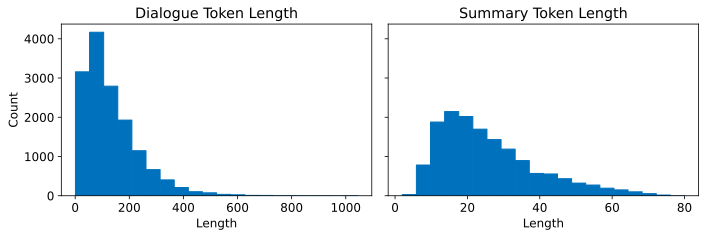

In [36]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [37]:
# Trainer를 위한 데이터 콜레이터 생성

def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
                                truncation=True)

    # with tokenizer.as_target_tokenizer():
    target_encodings = tokenizer(text_target=example_batch["summary"], max_length=128,
                                    truncation=True)

    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
                                       batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

토큰화 단계에서 새롭게 적용한 것은 tokenizer.as_target_tokenizer()임
- 인코더와 디코더 입력의 토큰화 구별을 위해 with문을 사용하면 토크나이저가 디코더를 위한 토큰화임을 인지하고 그에 따라 시퀀스를 처리할 수 있음

PEGASUS는 인코더-디코더 트랜스포머이고 , 고전적인 Seq2Seq 구조를 취함
- seq2seq 구조에서는 디코더에 '티처 포싱(teacher forcing)'을 적용하는 것이 일반적
- 이 전략에서는 디코더가 인코더 출력 외에 한 토큰이 이동된 레이블로 구성된 입력 토큰을 받음
  + 따라서 아래 표처럼 다음 토큰을 위한 예측을 만들 때 디코더는 한 토큰이 이동된 정답을 입력으로 받음

한 스텝 이동하면 그 다음 스텝의 레이블을 예측
- 디코더는 이전 스텝의 정답 레이블만 보며 현재와 미래의 레이블을 보지 못함
- 디코더는 현재와 미래의 모든 입력을 마스킹하는 마스크드 셀프 어텐션을 갖기 때문에 이동시키는 것으로 충분함

따라서, 배치를 준비할 때 레이블을 한 스텝 오른쪽으로 이동시켜 디코더 입력을 만듬
- 그런 다음 레이블에 있는 패딩 토큰에 -100으로 설정해 손실 함수가 무시하도록 만듬

다만, `DataCollatorForSeq2Seq`에서 이런 작업을 모두 처리하므로 실제로 이를 수동으로 할 필요는 없음


In [38]:
# 티처 포싱(teacher forcing)
# 텍스트 생성을 위한 디코더 입력과 레이블의 정렬
text = ['PAD','Transformers', 'are', 'awesome', 'for', 'text', 'summarization']
rows = []
for i in range(len(text)-1):
    rows.append({'step': i+1, 'decoder_input': text[:i+1], 'label': text[i+1]})
pd.DataFrame(rows).set_index('step')

,decoder_input,label
step,,
1,[PAD],Transformers
2,"[PAD, Transformers]",are
3,"[PAD, Transformers, are]",awesome
4,"[PAD, Transformers, are, awesome]",for
5,"[PAD, Transformers, are, awesome, for]",text
6,"[PAD, Transformers, are, awesome, for, text]",summarization


In [39]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [40]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10, push_to_hub=True,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16)

In [41]:
from huggingface_hub import notebook_login

notebook_login()

In [42]:
trainer = Trainer(model=model, args=training_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [43]:
trainer.train()
score = evaluate_summaries_pegasus(
    dataset_samsum["test"], rouge_metric, trainer.model, tokenizer,
    batch_size=2, column_text="dialogue", column_summary="summary")

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"pegasus"])

{'loss': 3.0125, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 3.0757, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 3.0213, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 2.9849, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 2.944, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 2.8877, 'learning_rate': 6e-06, 'epoch': 0.07}
{'loss': 2.8095, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.08}
{'loss': 2.6089, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.09}
{'loss': 2.6585, 'learning_rate': 9e-06, 'epoch': 0.1}
{'loss': 2.3516, 'learning_rate': 1e-05, 'epoch': 0.11}
{'loss': 2.3525, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.12}
{'loss': 2.242, 'learning_rate': 1.2e-05, 'epoch': 0.13}
{'loss': 2.1204, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.14}
{'loss': 2.1146, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.15}
{'loss': 2.0284, 'learning_rate': 1.5e-05, 'epoch': 0.16}
{'loss': 2.1071, 'learning

100%|██████████| 410/410 [07:38<00:00,  1.12s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.428731,0.198836,0.339624,0.339739


In [44]:
pd.DataFrame(rouge_dict, index=[f"pegasus"])

,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.428731,0.198836,0.339624,0.339739


In [45]:
trainer.push_to_hub("Training complete!")

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

events.out.tfevents.1707732704.1cc9b8e867e4.193.0:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/youngbreadho/pegasus-samsum/commit/920e1c48b6fb63cc23e54652ed6b3c9d1c2e3440', commit_message='Training complete!', commit_description='', oid='920e1c48b6fb63cc23e54652ed6b3c9d1c2e3440', pr_url=None, pr_revision=None, pr_num=None)

### 대화 요약 생성하기

In [46]:
import transformers
transformers.logging.set_verbosity_error()

In [47]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
pipe = pipeline("summarization", model="youngbreadho/pegasus-samsum")

print("대화:")
print(sample_text)
print("\n참조 요약:")
print(reference)
print("\n모델 요약:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

대화:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

참조 요약:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact
Larry.

모델 요약:
Amanda can't find Betty's number. Larry called Betty last time they were at the
park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


참조 번역과 비슷해짐
- 모델이 그냥 문장을 추출하지 않고 대화를 합성해서 요약을 만드는 법을 배운것 같음
- 임의로 작성한 대화에서 타당성 있는 요약을 생성함


In [48]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Thom, Lewis, Leandro and Leandro are going to write a book about transformers.
They are going to do it together, but it's not easy.


## 결론

텍스트 요약은 감성 분석, 개체명 인식, 질문 답변과 같이 분류 작업으로 구성되는 작업에 비해 특수한 어려움이 몇 가지 있음
- 정확도 같은 전통적인 지표는 생성된 텍스트의 품질을 반영하지 못함
- 이 장에서 보았듯이 BLEU와 ROUGE 지표가 생성된 텍스트를 잘 평가하지만 사람의 판단이 필요한 경우도 많음

요약 모델로 작업할 때는 주로 모델의 문맥 크기보다 긴 텍스트를 어떻게 요약할지에 의문이 생김
- 안타깝게도 이 문제를 해결할 수 있는 단일 전략은 없음
- 아직까지도 활발하게 연구되고 있는 문제
  * OpenAI의 최근 연구는 긴 문서에서 반복적으로 모델을 적용하고 사람의 피드백을 반복 루프에 추가해 요약 작업의 스케일을 확장하